In [75]:
import pandas as pd
from pandas_datareader import data, wb
import datetime

In [76]:
start = pd.to_datetime('2015-09-24')
end = pd.to_datetime('2020-09-24')
data_df = data.DataReader('AAPL','yahoo',start,end)
data_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-09-24,28.875000,28.092501,28.312500,28.750000,200878000.0,26.568277
2015-09-25,29.172501,28.504999,29.110001,28.677500,224607600.0,26.501280
2015-09-28,28.642500,28.110001,28.462500,28.110001,208436000.0,25.976849
2015-09-29,28.377501,26.965000,28.207500,27.264999,293461600.0,25.195972
2015-09-30,27.885000,27.182501,27.542500,27.575001,265892000.0,25.482449
...,...,...,...,...,...,...
2020-09-18,110.879997,106.089996,110.400002,106.839996,287104900.0,106.839996
2020-09-21,110.190002,103.099998,104.540001,110.080002,195713800.0,110.080002
2020-09-22,112.860001,109.160004,112.680000,111.809998,183055400.0,111.809998


In [77]:
df1=data_df.reset_index()['Close']
df1

0        28.750000
1        28.677500
2        28.110001
3        27.264999
4        27.575001
           ...    
1255    106.839996
1256    110.080002
1257    111.809998
1258    107.120003
1259    108.220001
Name: Close, Length: 1260, dtype: float64

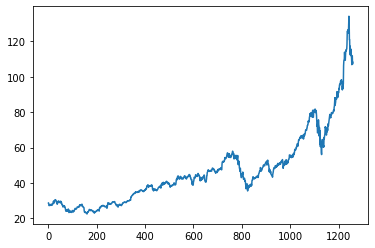

In [78]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [79]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
import numpy as np
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[0.05524442],
       [0.05459475],
       [0.0495094 ],
       ...,
       [0.79954302],
       [0.75751609],
       [0.76737315]])

In [80]:
training_size=int(len(df1)*0.80)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [81]:
training_size,test_size

(1008, 252)

In [82]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [83]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [84]:
print(X_train.shape), print(y_train.shape)

(907, 100)
(907,)


(None, None)

In [85]:
print(X_test.shape), print(ytest.shape)

(151, 100)
(151,)


(None, None)

In [86]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [88]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [89]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [90]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 1s 78ms/step - loss: 0.0074 - val_loss: 0.0763
Epoch 2/100
15/15 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0132
Epoch 3/100
15/15 [==============================] - 0s 15ms/step - loss: 5.0927e-04 - val_loss: 0.0067
Epoch 4/100
15/15 [==============================] - 0s 16ms/step - loss: 3.5664e-04 - val_loss: 0.0077
Epoch 5/100
15/15 [==============================] - 0s 15ms/step - loss: 2.9815e-04 - val_loss: 0.0058
Epoch 6/100
15/15 [==============================] - 0s 15ms/step - loss: 2.9083e-04 - val_loss: 0.0066
Epoch 7/100
15/15 [==============================] - 0s 15ms/step - loss: 2.8175e-04 - val_loss: 0.0083
Epoch 8/100
15/15 [==============================] - 0s 16ms/step - loss: 2.8500e-04 - val_loss: 0.0082
Epoch 9/100
15/15 [==============================] - 0s 15ms/step - loss: 2.6162e-04 - val_loss: 0.0058
Epoch 10/100
15/15 [==============================] - 0s 15ms/step - los

In [91]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


In [92]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [93]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

40.40601859318396

In [94]:
math.sqrt(mean_squared_error(ytest,test_predict))

84.61909272355511

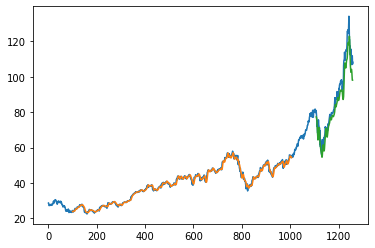

In [95]:
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [96]:
len(test_data)

252

In [97]:
x_input=test_data[152:].reshape(1,-1)
x_input.shape

(1, 100)

In [98]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.46422333689000306,
 0.47110090197025656,
 0.47806802758108835,
 0.4923832187083882,
 0.5033156197188771,
 0.4952507281236953,
 0.486827389305748,
 0.4910614830307749,
 0.4869617984684329,
 0.5032035665054282,
 0.49912637462595666,
 0.5127694515730146,
 0.507437660230455,
 0.5120077768621942,
 0.5071688419050852,
 0.5102603210136557,
 0.5105739879711321,
 0.5098795178416542,
 0.5186388795663138,
 0.5219768210510182,
 0.5259644523999112,
 0.5196917969185572,
 0.5402572192111578,
 0.5446480780481056,
 0.5682378432347515,
 0.5880640151325849,
 0.55011427855335,
 0.5566109720947846,
 0.5659975993675797,
 0.5863614079161528,
 0.5852637102986201,
 0.5855773772560965,
 0.5810744652056997,
 0.6015726829169579,
 0.6187329591435116,
 0.6042385785882376,
 0.6149469415386459,
 0.5898338269303594,
 0.6080918007744457,
 0.6148573126412502,
 0.6133115389035563,
 0.6133115389035563,
 0.6351315606592449,
 0.6325328695693075,
 0.6519781699283222,
 0.6556522026865562,
 0.6571531277921436,
 0.6531879207

In [99]:
from numpy import array
lst_output=[]
n_steps=100
i=0
while(i<11):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day Prediction {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

1 day Prediction [[0.63752156]]
2 day Prediction [[0.58846086]]
3 day Prediction [[0.531679]]
4 day Prediction [[0.4721555]]
5 day Prediction [[0.4120253]]
6 day Prediction [[0.35212106]]
7 day Prediction [[0.29292917]]
8 day Prediction [[0.23515932]]
9 day Prediction [[0.17995913]]
10 day Prediction [[0.1287609]]


In [100]:
print(lst_output)
print(len(lst_output))

[[0.6693484783172607], [0.6375215649604797], [0.5884608626365662], [0.5316789746284485], [0.47215551137924194], [0.4120253026485443], [0.3521210551261902], [0.29292917251586914], [0.23515932261943817], [0.17995913326740265], [0.1287609040737152]]
11


In [101]:
import itertools
b = lst_output
c =list(itertools.chain.from_iterable(b))
print(c)


[0.6693484783172607, 0.6375215649604797, 0.5884608626365662, 0.5316789746284485, 0.47215551137924194, 0.4120253026485443, 0.3521210551261902, 0.29292917251586914, 0.23515932261943817, 0.17995913326740265, 0.1287609040737152]


In [106]:
def Predicted_results():
  e = scaler.inverse_transform(b)
  return e
final = Predicted_results()
final

array([[97.28093823],
       [93.72921404],
       [88.25428528],
       [81.91771085],
       [75.27519035],
       [68.56496009],
       [61.87994597],
       [55.27442821],
       [48.82760219],
       [42.66753741],
       [36.95407135]])

In [107]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [108]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

my_model
assets	saved_model.pb	variables


In [109]:
model.save('my_model.h5') 